In [1]:
import numpy as np
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.stats import multivariate_normal
import time
import random
from scipy.linalg import block_diag
from sklearn.metrics import precision_recall_curve, auc
import scipy.stats
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import random
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
from collections import defaultdict

import sys
# sys.path.append('/Users/yijwang-admin/Documents/Research/GFL/Code/PQN_Python_main')
from minConf.minConf_PQN import minConF_PQN
import random
import itertools
import os
import matlab.engine

In [2]:
import numpy as np
from scipy.sparse import spdiags
from scipy.linalg import inv
from gurobipy import Model, GRB, QuadExpr

def Lasso(u, X, y, rho):
    n, d = X.shape
    D_u = spdiags(u.flatten(), 0, d, d)
    M = inv((1/rho) * X @ D_u @ X.T + np.eye(n))
    f = y.T @ M @ y
    g = -(1/rho) * ((X.T @ M @ y)**2)

    return f, g

def GroupLasso(u, X, y, rho):
    n, d = X.shape
    D_u = spdiags(u.flatten(), 0, d, d)
    M = inv((1/rho) * X @ D_u @ X.T + np.eye(n))
    f = y.T @ M @ y
    g = -(1/(2*rho)) * ((X.T @ M @ y)**2)

    return f, g

def GeneralizedFusedLasso(u, X, y, rho, L, mu):
    n, d = X.shape
    D_u = spdiags(u.flatten(), 0, d, d)
    M = inv((1/rho) * X @ D_u @ X.T + np.eye(n))
    f = (1/2) * y.T @ M @ y + mu * u.T @ L @ u
    g = -(1/(2*rho)) * ((X.T @ M @ y)**2) + 2 * mu * L @ u

    return f.flatten(), g.flatten()


def ProjLassoGurobi(u, k, d):
    A = np.ones((1, d))
    b = np.array([k])
    Q = np.eye(d)
    f = -2 * u.flatten()

    model = Model("GeneralizedFusedLasso")
    x = model.addMVar(d, lb=0.0, ub=1.0)

    model.setObjective(x@Q@x + x@f)
    model.addConstr(A @ x == b)

    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    model.optimize()
    # print("Lasso x.x: ", x.x)

    return x.x

def ProjGroupLassoGurobi(u, k, groups, h, d):
    """
    Solves the Group Lasso projection problem using Gurobi.

    Parameters:
    - u: Input vector of size (d, 1)
    - k: Sparsity level (L1 constraint)
    - groups: List of groups, where each group is a list of indices
    - h: Sum constraint for group norms

    Returns:
    - up: Projected vector (u')
    - zp: Auxiliary variables for group norms
    """
    # d = u.shape  # Number of variables
    g = len(groups)  # Number of groups

    # Quadratic objective matrices and linear term
    H1 = np.eye(d)  # Identity for quadratic term on `u`
    f1 = -2 * u.flatten()  # Linear term for `u`
    H2 = np.zeros((g, g))  # No quadratic term for auxiliary variables
    f2 = np.zeros(g)  # No linear term for auxiliary variables

    # Combine H1, H2 and f1, f2 into block matrices
    H = np.block([[H1, np.zeros((d, g))], [np.zeros((g, d)), H2]])
    f = np.concatenate([f1, f2])

    # Constraint matrices for `u` (A1) and `z` (A2)
    A1 = np.vstack([np.ones((1, d)), -np.ones((1, d))])  # L1 constraint on `u`
    A2 = np.zeros((2, g))  # Initialize A2
    group_constraints_count = 0

    # Build group constraints
    for i, group in enumerate(groups):
        for idx in group:
            A1_row = np.zeros((1, d))
            A1_row[0, idx] = 1
            A1 = np.vstack([A1, A1_row])  # Adding constraints for group indices

            A2_row = np.zeros((1, g))
            A2_row[0, i] = -1
            A2 = np.vstack([A2, A2_row])  # Adding constraints for group norms
            group_constraints_count += 1

    # Add overall group norm constraint
    A1 = np.vstack([A1, np.zeros((1, d))])
    A2 = np.vstack([A2, np.ones((1, g))])
    A = np.hstack([A1, A2])  # Combine A1 and A2

    # RHS vector for constraints
    b = np.zeros(group_constraints_count + 3)
    b[0] = k  # Sparsity constraint (sum of u <= k)
    b[1] = -k + 1  # Lower bound for sparsity
    b[-1] = h  # Sum constraint for group norms

    # Lower and upper bounds for variables
    lb = np.zeros(d + g)
    ub = np.ones(d + g)

    # Setup Gurobi model
    model = Model("ProjGroupLasso")
    x = model.addMVar(d + g, lb=lb, ub=ub)  # Variables for `u` and `z`

    # Set quadratic objective
    model.setObjective(x @ H @ x + x @ f)

    # Add constraints
    model.addConstr(A @ x <= b)

    # Configure Gurobi parameters
    model.setParam('OutputFlag', 0)  # Suppress output
    model.setParam('IterationLimit', 500)
    # Solve the model
    model.optimize()

    # Extract the results
    up = x.x[:d]  # Projected vector `u'`
    zp = x.x[d:]  # Auxiliary variables `z'`

    # print("GroupLasso x.x: ", up[:, np.newaxis])

    return up


def ProjGeneralizedFusedLassoGurobi(u, k, d):
    A = np.ones((1, d))
    b = np.array([k])
    c = np.array([k-1])
    
    # A = np.vstack([A, -np.ones((1, d))])
    # b = np.vstack([b, -k + 1])
    Q = np.eye(d)
    f = -2 * u.flatten()

    model = Model("GeneralizedFusedLasso")
    x = model.addMVar(d, lb=0.0, ub=1.0)

    model.setObjective(x@Q@x + x@f)
    model.addConstr(A @ x <= b)
    # model.addConstr(A @ x >= c)

    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    model.optimize()
    # print("GeneralizedFusedLasso x.x: ", x.x)

    return x.x

In [30]:
class RandomEnsemble:
    def __init__(self, n, d, k, h_total, h_selected, h_rest, gamma, 
                 p=0.95, q=0.01, 
                 options=None, num_replications=20,
                 datafile=f'./code_fgfl_aaai14/data_gfl/',
                 resultfile='./code_fgfl_aaai14/result_gfl/'):
        assert h_total == h_selected + h_rest, "h_total should be equal to h_selected + h_rest"
        self.n = n
        self.d = d
        self.k = k
        self.h_total = h_total
        self.h_selected = h_selected
        self.h_rest = h_rest
        self.gamma = gamma
        self.p = p
        self.q = q
        self.options = options if options else {'maxIter': 500, 'verbose': 0, ''}
        self.num_replications = num_replications
        self.datafile = os.path.join(os.path.abspath(datafile), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self.resultfile = os.path.join(os.path.abspath(resultfile), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}') # matlab does not like relative path
        self.best_rho1 = 0.5
        self.best_rho2 = 0.5
        self.best_mu = 1.0
        self.best_rho = np.sqrt(self.n) * 13.4 * k
        self.datafile_pqn = os.path.join(os.path.abspath('./PQN/data/'), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self.resultfile_pqn = os.path.join(os.path.abspath('./PQN/result/'), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self._init(self.datafile, self.resultfile)
        self._init(self.datafile_pqn, self.resultfile_pqn)

    
    def _init(self, datafile, resultfile):
        if not os.path.exists(datafile):
            os.makedirs(datafile)
        if not os.path.exists(resultfile):
            os.makedirs(resultfile)

    def _random_partition(self):
        # partition the first k nodes into h_selected groups and the rest into h_rest groups
        assert self.h_selected <= self.k, "h_selected should be less than k"
        assert self.h_rest <= self.d - self.k, "h_rest should be less d-k"
        break_points = np.sort(random.sample(range(1, self.k), self.h_selected-1))
        break_points_rest = np.sort(random.sample(range(self.k+1, self.d), self.h_rest-1))

        return break_points, break_points_rest
    
    def _generate_clusters(self):
        break_points, break_points_rest = self._random_partition()
        clusters = []
        clusters.append(np.arange(break_points[0])) # first selected cluster
        for i in range(1, self.h_selected-1):
            clusters.append(np.arange(break_points[i-1], break_points[i]))
        clusters.append(np.arange(break_points[-1], self.k)) # last selected cluster

        clusters.append(np.arange(self.k, break_points_rest[0])) # first rest cluster
        for i in range(1, self.h_rest-1):
            clusters.append(np.arange(break_points_rest[i-1], break_points_rest[i]))
        clusters.append(np.arange(break_points_rest[-1], self.d))

        return clusters

    def _generate_graph(self):
        # here we generate the adjacency matrix and laplacian of the graph
        clusters = self._generate_clusters()

        A = sp.lil_matrix((self.d, self.d))
        
        # generate thr inner cluster connections
        for cluster in clusters:
            cluster_size = len(cluster)
            block = (np.random.rand(cluster_size, cluster_size) < self.p).astype(int)
            np.fill_diagonal(block, 0) # no self-loop
            block = np.triu(block) + np.triu(block, 1).T # make it symmetric
            for i, node_i in enumerate(cluster):
                for j, node_j in enumerate(cluster):
                    A[node_i, node_j] = block[i, j]

        # generate the connections between clusters
        for i in range(self.h_total):
            for j in range(i+1, self.h_total):
                cluster_i = clusters[i]
                cluster_j = clusters[j]
                block = (np.random.rand(len(cluster_i), len(cluster_j)) < self.q).astype(int)
                for m, node_i in enumerate(cluster_i):
                    for n, node_j in enumerate(cluster_j):
                        A[node_i, node_j] = block[m, n]
                        A[node_j, node_i] = block[m, n]

        # TODO: check if the graph is connected and make it connected if not 
        # (optional, maybe not necessary)
        D = sp.diags(np.ravel(A.sum(axis=1)))
        L = D - A
        return L, clusters, A
    
    def _visualize_graph(self, A):
        # if we want to visualize the graph, we need to change it to array rather than sparse matrix
        A_arr = A.toarray()
        plt.figure(figsize=(8, 8))
        plt.title('Adjacency matrix')
        plt.spy(A_arr)
        plt.axis('off')
        plt.show()

    def _generate_w(self, clusters):
        w = np.zeros(self.d)
        for i in range(self.h_selected):
            cluster_sign = np.random.choice([-1, 1])
            cluster_weight = cluster_sign * (1 / np.sqrt(self.k)) # TODO: make more choice other than 1/sqrt(k)
            for node in clusters[i]:
                w[node] = cluster_weight
        # w = w[:, np.newaxis]
        return w

    def _generate_X(self):
        # X = np.random.normal(0, 1, (self.n, self.d))
        mean = np.zeros(self.d)
        cov = np.eye(self.d)
        X = np.random.multivariate_normal(mean, cov, self.n)
        return X
    
    def _generate_y(self, X, w):
        signal = X @ w
        noise = np.random.normal(0, self.gamma, signal.shape)
        y = signal + noise
        SNR = self._compute_snr(signal, noise)
        if 0: # TODO: add a debug/verbose flag
            print(f'SNR: {SNR}')

        return y

    def _generate_data(self):
        L, clusters, A = self._generate_graph()
        if 0: # TODO: add a debug/verbose flag 
            self._visualize_graph(A)
        w = self._generate_w(clusters)
        X = self._generate_X()
        y = self._generate_y(X, w)
        return L, w, X, y, clusters, A


    def _compute_snr(self, signal, noise):  
        # in our case, the snr is 10*log10(1/gamma^2)
        signal = np.asarray(signal)
        noise = np.asarray(noise)

        signal_power = np.mean(signal ** 2)
        noise_power = np.mean(noise ** 2)
        
        snr = signal_power / noise_power
        snr_db = 10 * np.log10(snr)
        
        return snr_db
    
    def _define_obj(self, model, X, y, rho=1, L=None, mu=None):
        """
        Support models: 'Lasso', GroupLasso', 'GeneralizedFusedLasso'
        I plan to support Proximal method by calling matlab session
        this part and the one below is to support PQN, the Proxiaml method is on its own, it does not need this
        """
        if model == "Lasso":
            return lambda u: Lasso(u, X, y, rho)
        elif model == "GroupLasso":
            return lambda u: GroupLasso(u, X, y, rho)
        elif model == "GeneralizedFusedLasso":
            return lambda u: GeneralizedFusedLasso(u, X, y, rho, L, mu)
        else:
            raise ValueError("Model not supported")
        
    def _define_projection(self, model, groups=None):
        """
        Support models: 'Lasso', GroupLasso', 'GeneralizedFusedLasso'
        """
        if model == "Lasso":
            return lambda u: ProjLassoGurobi(u, self.k, self.d)
        elif model == "GroupLasso":
            return lambda u: ProjGroupLassoGurobi(u, self.k, groups, self.h_selected, self.d)
        elif model == "GeneralizedFusedLasso":
            return lambda u: ProjGeneralizedFusedLassoGurobi(u, self.k, self.d)
        else:
            raise ValueError("Model not supported")
        
    def _max_degree(self, L):
        # find the maximum degree of the graph according to the laplacian matrix
        return np.max(np.diag(L.toarray()))
    
    def solver(self, model, X, y, clusters=None, L=None, A=None, i=None, rho=1, mu=1):
        if model == "Proximal":
            return self._solver_proximal(X, y, A, i)
        elif model == "Lasso":
            rho = np.sqrt(self.n) # TODO: check if this is the correct value
            funObj = self._define_obj(model, X, y, rho)
            funProj = self._define_projection(model)
        elif model == "GroupLasso":
            rho = np.sqrt(self.n) # TODO: check if this is the correct value
            funObj = self._define_obj(model, X, y, rho)
            funProj = self._define_projection(model, clusters)
        elif model == "GeneralizedFusedLasso":
            # max_degree = self._max_degree(L)
            # rho = 3.4 * self.k * 2 * mu * 2 * max_degree  # TODO: check if this is the correct value
            # rho = np.sqrt(self.n) # TODO: check if this is the correct value
            if i == 0:
                # rho_values = [1, 10, np.sqrt(self.n), 50, 70, 100] # sqrt(300)=17.32
                # rho_values = [10, np.sqrt(self.n), 50, 100]
                rho_values = [0.1, 0.5, 1.0, 5.0]
                mu_values = [0.01, 0.1, 1.0]
                self.best_rho, self.best_mu = self._cross_validation_gfl(X, y, L, rho_values, mu_values)
            else:
                rho = self.best_rho
                mu = self.best_mu
            funObj = self._define_obj(model, X, y, rho, L, mu)
            funProj = self._define_projection(model)
        elif model == "GFL_Matlab":
            # rho = np.sqrt(self.n) # TODO: check if this is the correct value
            # mu = 1.0
            return self._solver_gfl(X, y, L, rho, mu, i)
        else:
            raise ValueError("Model not supported")
        
        uSimplex = np.ones((self.d, 1)) / self.d
        uout, obj, _ = minConF_PQN(funObj, uSimplex, funProj, self.options)
        # uout = funProj(uout) # TODO: check if this is necessary

        self._save_result(uout, f'./res/result_{model}_{i}.mat')

        return uout
    
    def _solver_gfl(self, X, y, L, rho, mu, i):
        datafile_pqn = os.path.join(self.datafile_pqn, f'data_{i}.mat')
        resultfile_pqn = os.path.join(self.resultfile_pqn, f'result_{i}.mat')
        # if i == 0:
        #     rho_values = [0.1, 0.5, 1.0, np.sqrt(self.n), 30]
        #     mu_values = [0.01, 0.1, 1.0, 5.0]
        #     self.best_rho, self.best_mu = self._cross_validation_gfl(X, y, L, rho_values, mu_values)
        #     print(f"Best rho: {self.best_rho}, Best mu: {self.best_mu}")
        self._save_mat_pqn(X, y, L, datafile_pqn)
        self._call_gfl(datafile_pqn, resultfile_pqn, self.best_rho, self.best_mu)
        u, _ = self._read_result(resultfile_pqn)
        return u.flatten()
    
    def _save_mat_pqn(self, X, y, L, filename=None):
        # save the data to .mat file so that the matlab code of proxiaml can use it
        # print("X.shape", X.shape)   
        # print("y.shape", y.shape)
        # print("A.shape", A.shape)
        if y.ndim == 1:
            y = y[:, np.newaxis]
        data = {
            "X": X,
            "y": y,
            "L": L.toarray() if sp.issparse(L) else L,  # we store the adjacency matrix as dense matrix
        }
        sio.savemat(filename, data)

    
    def _call_gfl(self, datafile, resultfile, rho, mu):
        eng = matlab.engine.start_matlab()
        try:
            eng.cd(os.path.abspath('./PQN/'))
            eng.addpath(os.path.abspath('./PQN/'))
            eng.addpath(eng.genpath(os.path.abspath('./PQN/')))
            eng.addpath(eng.genpath(os.path.abspath('./PQN/minConF/')))
            eng.gfl_pqn(datafile, resultfile, rho, mu, nargout=0)
        finally:
            eng.quit()
    
    def _save_result(self, u, filename):
        sio.savemat(filename, {'beta': u})
    
    def _gfl_helper(self, X, y, L, rho, mu):
        funObj = self._define_obj("GeneralizedFusedLasso", X, y, rho, L, mu)
        funProj = self._define_projection("GeneralizedFusedLasso")
        uSimplex = np.ones((self.d, 1)) / self.d
        uout, obj, _ = minConF_PQN(funObj, uSimplex, funProj, self.options)
        uout = funProj(uout) # TODO: check if this is necessary

        return uout

    
    def _call_proximal(self, datafile, resultfile, rho1, rho2):
        eng = matlab.engine.start_matlab()
        try:
            eng.cd(os.path.abspath('./code_fgfl_aaai14/'))
            eng.addpath(os.path.abspath('./code_fgfl_aaai14/GFL/'))
            eng.addpath(eng.genpath(os.path.abspath('./code_fgfl_aaai14/')))
            eng.gfl_proximal(datafile, resultfile, rho1, rho2, nargout=0)
        finally:
            eng.quit()

    def _cross_validation(self, X, y, A, rho1_values, rho2_values, k_folds=5):
        results = []
        n = self.n
        indices = np.arange(n)
        np.random.shuffle(indices)
        folds = np.array_split(indices, k_folds)
        datafile = os.path.join(self.datafile, 'data.mat') 
        resultfile = os.path.join(self.resultfile, 'result.mat')

        for rho1, rho2 in itertools.product(rho1_values, rho2_values):
            mse_list = []
            for fold in folds:
                train_indices = np.setdiff1d(indices, fold)
                test_indices = fold
                X_train, y_train = X[train_indices], y[train_indices]
                X_test, y_test = X[test_indices], y[test_indices]

                self._save_mat(X_train, y_train, A, datafile)
                self._call_proximal(datafile, resultfile, rho1, rho2)
                u, funcVal = self._read_result(resultfile)      
                mse = np.mean((X_test @ u - y_test) ** 2)
                mse_list.append(mse)

            avg = np.mean(mse_list)
            results.append((rho1, rho2, avg))

        best_rho1, best_rho2, _ = min(results, key=lambda x: x[2])
        return best_rho1, best_rho2
    
    def _cross_validation_gfl(self, X, y, L, rho_values, mu_values, k_folds=5):
        results = []
        n = self.n
        indices = np.arange(n)
        np.random.shuffle(indices)
        folds = np.array_split(indices, k_folds)
        datafile = os.path.join(self.datafile_pqn, 'data.mat')
        resultfile = os.path.join(self.resultfile_pqn, 'result.mat')

        for rho, mu in itertools.product(rho_values, mu_values):
            acc_list = []
            for fold in folds:
                train_indices = np.setdiff1d(indices, fold)
                test_indices = fold
                X_train, y_train = X[train_indices], y[train_indices]
                # X_test, y_test = X[test_indices], y[test_indices]
                self._save_mat_pqn(X_train, y_train, L, datafile)
                self._call_gfl(datafile, resultfile, rho, mu)
                u, _ = self._read_result(resultfile)
                acc_score = self.recovery_accuracy(u)
                acc_list.append(acc_score)
                

            avg = np.mean(acc_list)
            results.append((rho, mu, avg))
            print(f"rho: {rho}, mu: {mu}, acc: {avg}")
        
        
        best_rho, best_mu, _ = max(results, key=lambda x: x[2])
        print(f"Best rho: {best_rho}, Best mu: {best_mu}")
        return best_rho, best_mu

    def _read_result(self, resultfile):
        result = sio.loadmat(resultfile)
        beta, funcVal = result['beta'], result['funcVal']
        return beta, funcVal
        
    def _solver_proximal(self, X, y, A, i):
        # rho1_values = [0.1, 0.5, 1.0, 5.0]
        # rho2_values = [0.1, 0.5, 1.0, 5.0]
        # if i == 0: # we only do cross validation once and use the best rho1 and rho2 for the rest of the replications
        #     self.best_rho1, self.best_rho2 = self._cross_validation(X, y, A, rho1_values, rho2_values)
        #     print(f"Best rho1: {self.best_rho1}, Best rho2: {self.best_rho2}")

        datafile_name = os.path.join(self.datafile, f'data_{i}.mat')
        resultfile_name = os.path.join(self.resultfile, f'result_{i}.mat')
        self._save_mat(X, y, A, datafile_name)
        self._call_proximal(datafile_name, resultfile_name, self.best_rho1, self.best_rho2)
        u, funcVal = self._read_result(resultfile_name)
        return u.flatten() # the original return a vector with shape (d,1), will not work with recovery_accuracy

    def recovery_accuracy(self, u):
        # evaluate the support recovery accuracy
        # we take top k for u
        selected_features_true = np.arange(self.k)
        selected_features_pred = np.argsort(np.abs(u))[-self.k:] # take absolute value for proximal method
        correct_pred = np.intersect1d(selected_features_true, selected_features_pred)
        accuracy = len(correct_pred) / self.k
        return accuracy
    
    def _save_mat(self, X, y, A, filename=None):
        # save the data to .mat file so that the matlab code of proxiaml can use it
        # print("X.shape", X.shape)   
        # print("y.shape", y.shape)
        # print("A.shape", A.shape)
        if y.ndim == 1:
            y = y[:, np.newaxis]
        data = {
            "X": X,
            "y": y,
            "AdjMat": A.toarray() if sp.issparse(A) else A,  # we store the adjacency matrix as dense matrix
        }
        sio.savemat(filename, data)

    def _report(self, model_accuracy):
        for model, accuracy in model_accuracy.items():
            avg_accuracy = np.mean(accuracy)
            std_accuracy = np.std(accuracy)
            print(f"Model: {model}, Avg. Accuracy: {avg_accuracy}, Std. Accuracy: {std_accuracy}")

    def main(self):
        # models = ["Proximal", "Lasso", "GroupLasso", "GeneralizedFusedLasso"]
        # models = ["GeneralizedFusedLasso", "Proximal"]
        models = ["GFL_Matlab", "Proximal"]
        model_accuracy = defaultdict(list)
        for i in range(self.num_replications):
            L, w, X, y, clusters, A = self._generate_data()
            for model in models:
                print(f"Synthetic dataset {i+1}: Running {model} model")
                u = self.solver(model, X, y, clusters, L, A, i)
                accuracy = self.recovery_accuracy(u)
                model_accuracy[model].append(accuracy)

        self._report(model_accuracy)
        return model_accuracy
    
# TODO: solve the orginal problem and calculate the MSE?


class RandomEnsembleWeight(RandomEnsemble):
    def _generate_w(self, clusters):
        w = np.zeros(self.d)
        cluster_weights = []

        # Generate non-zero random weights for clusters
        for _ in range(self.h_selected):
            cluster_sign = np.random.choice([-1, 1])
            cluster_weight = np.random.choice([0.5, 1.0, 2.0, 99.0, 100.0])
            cluster_weights.append(cluster_sign * cluster_weight)

        # Normalize the cluster weights to ensure the sum of squares is 1
        cluster_weights = np.array(cluster_weights)
        cluster_weights /= np.linalg.norm(cluster_weights)  # Normalize to make sum of squares = 1

        # Assign the same weight to all nodes in each cluster
        for i, cluster in enumerate(clusters[:self.h_selected]):
            for node in cluster:
                w[node] = cluster_weights[i]

        return w
    

In [8]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=10, h_selected=2, h_rest=8, gamma=0.5, p=0.5, q=0.05, num_replications=50)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
Set parameter Username
Set parameter LicenseID to value 2585252
Set parameter LogToConsole to value 0
rho: 1, mu: 0.01, mse: 30.99016867936035
rho: 1, mu: 0.05, mse: 24.018512938688037
rho: 1, mu: 0.1, mse: 22.7776996164673
rho: 1, mu: 0.2, mse: 21.990895330195944
rho: 1, mu: 0.3, mse: 21.657902230920968
rho: 1, mu: 0.4, mse: 21.485206731085007
rho: 1, mu: 0.5, mse: 21.35477120928623
rho: 10, mu: 0.01, mse: 51.248215908645726
rho: 10, mu: 0.05, mse: 36.27603995856663
rho: 10, mu: 0.1, mse: 30.088035434811253
rho: 10, mu: 0.2, mse: 26.496812319633598
rho: 10, mu: 0.3, mse: 25.03764700230608
rho: 10, mu: 0.4, mse: 24.299389748304463
rho: 10, mu: 0.5, mse: 23.75425928990675
rho: 17.320508075688775, mu: 0.01, mse: 52.95477977421474
rho: 17.320508075688775, mu: 0.05, mse: 41.76618344478357
rho: 17.320508075688775, mu: 0.1, mse: 33.721551605099904
rho: 17.320508075688775, mu: 0.2, mse: 28.81520614982632
rho: 17.320508075688775, mu: 0.3

defaultdict(list,
            {'GeneralizedFusedLasso': [0.84,
              0.9,
              0.82,
              0.94,
              0.96,
              0.84,
              0.82,
              0.92,
              0.94,
              0.74,
              0.7,
              0.9,
              0.84,
              0.74,
              0.98,
              0.78,
              0.88,
              0.78,
              0.98,
              0.86,
              0.82,
              0.98,
              0.94,
              0.9,
              0.94,
              0.54,
              0.88,
              0.98,
              0.72,
              0.84,
              0.84,
              0.92,
              0.92,
              0.94,
              0.66,
              0.64,
              0.98,
              0.98,
              0.84,
              0.94,
              0.88,
              0.98,
              0.98,
              0.72,
              0.76,
              0.88,
              0.84,
              0.84,
 

In [16]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=25, h_selected=5, h_rest=20, gamma=0.5, p=0.5, q=0.02, num_replications=50)
random_ensemble.main()

KeyboardInterrupt: 

In [11]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=25, h_selected=5, h_rest=20, gamma=0.1, p=0.7, q=0.02, num_replications=50)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 1, mu: 0.01, mse: 31.775462972757595
rho: 1, mu: 0.05, mse: 19.77602430567603
rho: 1, mu: 0.1, mse: 17.117136560471685
rho: 1, mu: 0.2, mse: 15.30929293850013
rho: 1, mu: 0.3, mse: 14.617198691718476
rho: 1, mu: 0.4, mse: 14.157695138197955
rho: 1, mu: 0.5, mse: 13.885976554537596
rho: 10, mu: 0.01, mse: 66.21562132914733
rho: 10, mu: 0.05, mse: 39.4266978463424
rho: 10, mu: 0.1, mse: 30.497776580291806
rho: 10, mu: 0.2, mse: 23.92715425889235
rho: 10, mu: 0.3, mse: 21.39631695750702
rho: 10, mu: 0.4, mse: 19.76977561922767
rho: 10, mu: 0.5, mse: 18.75823540125868
rho: 17.320508075688775, mu: 0.01, mse: 72.27770542377903
rho: 17.320508075688775, mu: 0.05, mse: 46.69758745490274
rho: 17.320508075688775, mu: 0.1, mse: 35.788915612464145
rho: 17.320508075688775, mu: 0.2, mse: 27.600712729691953
rho: 17.320508075688775, mu: 0.3, mse: 24.167690924377503
rho: 17.320508075688775, mu: 0.4, mse: 22.141037651209665
rho: 17.32050807568

defaultdict(list,
            {'GeneralizedFusedLasso': [0.92,
              0.72,
              0.7,
              0.86,
              0.78,
              0.84,
              0.86,
              0.76,
              0.92,
              0.74,
              0.68,
              0.94,
              0.9,
              0.9,
              0.6,
              0.38,
              0.72,
              0.72,
              0.92,
              0.96,
              0.62,
              0.98,
              0.68,
              0.82,
              0.6,
              0.88,
              0.78,
              0.76,
              0.6,
              0.64,
              0.48,
              0.9,
              0.84,
              0.62,
              0.76,
              0.72,
              0.92,
              0.86,
              0.92,
              0.82,
              0.9,
              0.9,
              0.84,
              0.88,
              0.76,
              0.98,
              0.66,
              0.86,
      

In [13]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=10, h_selected=2, h_rest=8, gamma=0.5, p=0.5, q=0.05, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 1, mu: 0.01, mse: 9.617052980592351
rho: 1, mu: 0.05, mse: 15.459962210396165
rho: 1, mu: 0.1, mse: 17.788778045227282
rho: 1, mu: 0.2, mse: 19.7827539128243
rho: 1, mu: 0.3, mse: 20.77296039312334
rho: 1, mu: 0.4, mse: 21.396265764766458
rho: 1, mu: 0.5, mse: 21.835468743964952
rho: 10, mu: 0.01, mse: 3.3854367256892957
rho: 10, mu: 0.05, mse: 7.516859126356771
rho: 10, mu: 0.1, mse: 10.191999254846266
rho: 10, mu: 0.2, mse: 12.76754142577613
rho: 10, mu: 0.3, mse: 14.293634356456895
rho: 10, mu: 0.4, mse: 15.368939466687346
rho: 10, mu: 0.5, mse: 16.179738527698696
rho: 17.320508075688775, mu: 0.01, mse: 3.5257607024671977
rho: 17.320508075688775, mu: 0.05, mse: 5.981389779726923
rho: 17.320508075688775, mu: 0.1, mse: 8.631754500543817
rho: 17.320508075688775, mu: 0.2, mse: 11.165718460813917
rho: 17.320508075688775, mu: 0.3, mse: 12.715132541593968
rho: 17.320508075688775, mu: 0.4, mse: 13.814959753052005
rho: 17.32050807

defaultdict(list,
            {'GeneralizedFusedLasso': [0.84,
              1.0,
              1.0,
              0.96,
              1.0,
              0.94,
              1.0,
              1.0,
              1.0,
              1.0],
             'Proximal': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]})

In [15]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=25, h_selected=5, h_rest=20, gamma=0.1, p=0.7, q=0.02, num_replications=50)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 1, mu: 0.01, mse: 15.392768483602765
rho: 1, mu: 0.05, mse: 12.752512485526626
rho: 1, mu: 0.1, mse: 13.076256550335728
rho: 1, mu: 0.2, mse: 13.690894921546171
rho: 1, mu: 0.3, mse: 14.094767201812243
rho: 1, mu: 0.4, mse: 14.37999178724344
rho: 1, mu: 0.5, mse: 14.595019013301476
rho: 10, mu: 0.01, mse: 25.697658129270348
rho: 10, mu: 0.05, mse: 18.797193593485837
rho: 10, mu: 0.1, mse: 14.762419009620672
rho: 10, mu: 0.2, mse: 13.037909288957863
rho: 10, mu: 0.3, mse: 12.705501338798488
rho: 10, mu: 0.4, mse: 12.665349056167964
rho: 10, mu: 0.5, mse: 12.715259973958364
rho: 17.320508075688775, mu: 0.01, mse: 25.95591087715614
rho: 17.320508075688775, mu: 0.05, mse: 22.185660762749723
rho: 17.320508075688775, mu: 0.1, mse: 17.034794265177418
rho: 17.320508075688775, mu: 0.2, mse: 13.87642731464246
rho: 17.320508075688775, mu: 0.3, mse: 13.008871979215613
rho: 17.320508075688775, mu: 0.4, mse: 12.713835178563281
rho: 17.320

defaultdict(list,
            {'GeneralizedFusedLasso': [0.76,
              0.88,
              0.7,
              0.84,
              0.92,
              0.9,
              0.94,
              0.98,
              0.98,
              0.92,
              0.94,
              0.78,
              0.56,
              0.94,
              0.74,
              0.94,
              0.98,
              0.96,
              0.98,
              0.98,
              0.62,
              0.8,
              0.88,
              0.96,
              0.58,
              0.82,
              0.88,
              0.84,
              0.92,
              0.9,
              0.9,
              0.84,
              0.9,
              0.88,
              0.82,
              0.84,
              0.66,
              0.88,
              0.88,
              1.0,
              0.78,
              0.96,
              0.76,
              0.88,
              0.8,
              1.0,
              0.68,
              0.74,
      

In [24]:
class RandomEnsembleWeight(RandomEnsemble):
    def _generate_w(self, clusters):
        w = np.zeros(self.d)
        cluster_weights = []

        # Generate non-zero random weights for clusters
        for _ in range(self.h_selected):
            cluster_sign = np.random.choice([-1, 1])
            cluster_weight = np.random.choice([0.5, 1.0, 2.0, 99.0, 100.0])
            cluster_weights.append(cluster_sign * cluster_weight)

        # Normalize the cluster weights to ensure the sum of squares is 1
        cluster_weights = np.array(cluster_weights)
        cluster_weights /= np.linalg.norm(cluster_weights)  # Normalize to make sum of squares = 1

        # Assign the same weight to all nodes in each cluster
        for i, cluster in enumerate(clusters[:self.h_selected]):
            for node in cluster:
                w[node] = cluster_weights[i]

        return w

In [16]:

random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.7, q=0.02, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 1, mu: 0.01, mse: 39.01525967707403
rho: 1, mu: 0.05, mse: 25.700128339413613
rho: 1, mu: 0.1, mse: 22.309171045436
rho: 1, mu: 0.2, mse: 19.850563213181253
rho: 1, mu: 0.3, mse: 18.734528501293617
rho: 1, mu: 0.4, mse: 18.058594071768518
rho: 1, mu: 0.5, mse: 17.592582515390138
rho: 10, mu: 0.01, mse: 45.01712561121288
rho: 10, mu: 0.05, mse: 41.33870599256973
rho: 10, mu: 0.1, mse: 38.30539173588987
rho: 10, mu: 0.2, mse: 31.533290852884456
rho: 10, mu: 0.3, mse: 28.304897938442274
rho: 10, mu: 0.4, mse: 26.374634617564823
rho: 10, mu: 0.5, mse: 25.05201689833276
rho: 17.320508075688775, mu: 0.01, mse: 47.43461296660187
rho: 17.320508075688775, mu: 0.05, mse: 42.11954932760726
rho: 17.320508075688775, mu: 0.1, mse: 41.2251242531912
rho: 17.320508075688775, mu: 0.2, mse: 36.33386186244602
rho: 17.320508075688775, mu: 0.3, mse: 32.24403841210071
rho: 17.320508075688775, mu: 0.4, mse: 29.748522313025127
rho: 17.32050807568877

defaultdict(list,
            {'GeneralizedFusedLasso': [0.18,
              0.4,
              0.34,
              0.42,
              0.12,
              0.74,
              0.46,
              0.58,
              0.66,
              0.66],
             'Proximal': [0.48,
              0.44,
              0.38,
              0.42,
              0.22,
              0.8,
              0.48,
              0.5,
              0.68,
              0.66]})

In [10]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.7, q=0.02, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GFL_Matlab model
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     1.39540e-05     9.26456e+02     2.99996e+02
         2          3         15     1.00000e+00     6.56237e+02     2.98504e+02
         3          4         26     1.00000e+00     5.29692e+02     2.97539e+02
         4          5         37     1.00000e+00     4.04234e+02     2.96237e+02
         5          6         49     1.00000e+00     3.16051e+02     2.95149e+02
         6          7         61     1.00000e+00     2.49037e+02     2.94850e+02
         7          8         73     1.00000e+00     2.01482e+02     2.95847e+02
         8          9         85     1.00000e+00     1.67363e+02     2.95303e+02
         9         10         97     1.00000e+00     1.45347e+02     2.87377e+02
        10         11        109     1.00000e+00     1.31472e+02     2.86411e+02
        11         12        121     1.00000e+00     1.16994e+

defaultdict(list,
            {'GFL_Matlab': [0.4,
              0.28,
              0.36,
              0.28,
              0.22,
              0.48,
              0.52,
              0.3,
              0.42,
              0.54],
             'Proximal': [0.4,
              0.28,
              0.32,
              0.42,
              0.16,
              0.44,
              0.48,
              0.26,
              0.46,
              0.52]})

In [18]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.7, q=0.02, num_replications=20)
random_ensemble.main()

Synthetic dataset 1: Running GFL_Matlab model
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     1.53959e-05     8.56614e+02     2.99995e+02
         2          3         15     1.00000e+00     6.05847e+02     2.98433e+02
         3          4         26     1.00000e+00     4.88171e+02     2.97386e+02
         4          5         37     1.00000e+00     3.70045e+02     2.95885e+02
         5          6         48     1.00000e+00     2.85438e+02     2.94517e+02
         6          7         60     1.00000e+00     2.17527e+02     2.92248e+02
         7          8         72     1.00000e+00     1.67094e+02     2.88758e+02
         8          9         84     1.00000e+00     1.29638e+02     2.82511e+02
         9         10         96     1.00000e+00     1.02921e+02     2.74247e+02
        10         11        108     1.00000e+00     8.44127e+01     2.66103e+02
        11         12        120     1.00000e+00     7.21190e+

defaultdict(list,
            {'GFL_Matlab': [0.44,
              0.34,
              0.32,
              0.46,
              0.22,
              0.4,
              0.5,
              0.64,
              0.2,
              0.56,
              0.28,
              0.7,
              0.6,
              0.28,
              0.54,
              0.46,
              0.58,
              0.18,
              0.18,
              0.58],
             'Proximal': [0.44,
              0.32,
              0.32,
              0.42,
              0.18,
              0.44,
              0.44,
              0.68,
              0.18,
              0.58,
              0.36,
              0.72,
              0.58,
              0.28,
              0.58,
              0.54,
              0.6,
              0.16,
              0.32,
              0.54]})

In [26]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=15, h_selected=5, h_rest=10, gamma=0.1, p=0.95, q=0.02, num_replications=20)
random_ensemble.main()

Synthetic dataset 1: Running GFL_Matlab model
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     2.25388e-03     4.02425e+03     2.99366e+02
         2          3         16     1.00000e+00     4.02084e+03     3.00312e+02
         3          4         27     1.00000e+00     4.01593e+03     3.00420e+02
         4          5         38     1.00000e+00     4.00852e+03     3.02146e+02
         5          6         49     1.00000e+00     4.00463e+03     2.96883e+02
         6          7         60     1.00000e+00     4.00183e+03     2.77481e+02
         7          8         71     1.00000e+00     3.99783e+03     2.73957e+02
         8          9         82     1.00000e+00     3.99304e+03     3.07124e+02
         9         10         93     1.00000e+00     3.98728e+03     3.08981e+02
        10         11        104     1.00000e+00     3.97693e+03     2.78146e+02
        11         12        115     1.00000e+00     3.97128e+

defaultdict(list,
            {'GFL_Matlab': [0.56,
              0.62,
              0.62,
              0.54,
              0.88,
              0.62,
              0.22,
              0.82,
              0.24,
              0.5,
              0.56,
              0.9,
              0.72,
              0.62,
              0.56,
              0.42,
              0.32,
              0.38,
              0.44,
              0.64],
             'Proximal': [0.6,
              0.64,
              0.64,
              0.48,
              1.0,
              0.46,
              0.14,
              1.0,
              0.14,
              0.46,
              0.52,
              0.92,
              0.66,
              0.66,
              0.5,
              0.34,
              0.48,
              0.26,
              0.32,
              0.64]})

In [27]:
random_ensemble = RandomEnsembleWeight(n=400, d=1000, k=50, h_total=15, h_selected=5, h_rest=10, gamma=0.1, p=0.95, q=0.02, num_replications=20)
random_ensemble.main()

Synthetic dataset 1: Running GFL_Matlab model
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     3.16020e-03     3.04143e+03     2.50982e+02
         2          3         16     1.00000e+00     3.03870e+03     3.98764e+02
         3          4         27     1.00000e+00     3.03535e+03     3.96488e+02
         4          5         38     1.00000e+00     3.03227e+03     3.97410e+02
         5          6         49     1.00000e+00     3.03008e+03     3.72214e+02
         6          7         61     1.00000e+00     3.02915e+03     3.76277e+02
         7          8         71     1.00000e+00     3.02634e+03     3.85083e+02
         8          9         82     1.00000e+00     3.02465e+03     3.81369e+02
         9         10         93     1.00000e+00     3.02117e+03     3.58643e+02
        10         11        104     1.00000e+00     3.01128e+03     3.43253e+02
        11         12        115     1.00000e+00     3.00768e+

defaultdict(list,
            {'GFL_Matlab': [0.66,
              0.86,
              0.42,
              0.76,
              0.58,
              0.64,
              0.42,
              0.26,
              0.9,
              0.76,
              0.08,
              0.42,
              0.98,
              0.38,
              0.72,
              0.34,
              0.24,
              0.44,
              0.44,
              0.54],
             'Proximal': [0.68,
              0.94,
              0.08,
              0.72,
              0.52,
              0.62,
              0.82,
              0.34,
              1.0,
              0.78,
              0.06,
              0.4,
              1.0,
              0.64,
              0.68,
              0.4,
              0.16,
              0.38,
              0.66,
              0.44]})

In [28]:
random_ensemble = RandomEnsembleWeight(n=800, d=1000, k=50, h_total=15, h_selected=5, h_rest=10, gamma=0.1, p=0.95, q=0.02, num_replications=20)
random_ensemble.main()

Synthetic dataset 1: Running GFL_Matlab model
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     5.75127e-03     1.87754e+03     1.45028e+02
         2          3         16     1.00000e+00     1.87418e+03     2.74671e+02
         3          4         27     1.00000e+00     1.86491e+03     3.93537e+02
         4          6         38     3.02676e-01     1.86359e+03     3.66498e+02
         5          7         50     1.00000e+00     1.86241e+03     2.28794e+02
         6          8         61     1.00000e+00     1.86196e+03     1.82615e+02
         7          9         73     1.00000e+00     1.86158e+03     1.83480e+02
         8         10         84     1.00000e+00     1.86095e+03     1.80816e+02
         9         11         95     1.00000e+00     1.86009e+03     1.75735e+02
        10         12        104     1.00000e+00     1.85890e+03     2.30324e+02
        11         13        115     1.00000e+00     1.85745e+

defaultdict(list,
            {'GFL_Matlab': [0.28,
              0.82,
              0.54,
              0.5,
              0.56,
              0.88,
              0.7,
              0.96,
              0.78,
              0.22,
              0.84,
              0.6,
              0.98,
              0.64,
              0.58,
              0.3,
              0.68,
              0.54,
              0.64,
              0.36],
             'Proximal': [0.86,
              0.94,
              1.0,
              0.56,
              0.98,
              1.0,
              0.88,
              1.0,
              0.82,
              0.9,
              1.0,
              0.66,
              0.98,
              0.72,
              0.68,
              0.62,
              0.9,
              0.78,
              0.64,
              0.34]})

In [29]:
sample_sizes = np.arange(0, 400, 50)
print(sample_sizes)

[  0  50 100 150 200 250 300 350]


In [31]:
sample_sizes = np.arange(50, 500, 50)
accuracy = []
for n in sample_sizes:
    random_ensemble = RandomEnsemble(n=n, d=1000, k=30, h_total=15, h_selected=3, h_rest=12, gamma=0.1, p=0.9, q=0.05, num_replications=50)
    accuracy.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
Synthetic dataset 1: Running Proximal model
10 12
10 12
10 12
10 12
10 12
10 12
10 12
10 12
8 10
8 10
8 10
7 9
7 9
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Proximal model
4 6
4 6
4 6
4 6
4 6
4 6
4 6
3 5
3 5
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Proximal model
7 9
7 9
7 9
7 9
7 9
7 9
7 9
7 9
7 9
7 9
8 10
8 10
Synthetic dataset 4: Running GFL_Matlab model
Synthetic dataset 4: Running Proximal model
11 13
11 13
11 13
11 13
11 13
11 13
11 13
11 13
9 11
8 10
6 8
6 8
5 7
6 8
Synthetic dataset 5: Running GFL_Matlab model
Synthetic dataset 5: Running Proximal model
6 8
6 8
6 8
6 8
6 8
6 8
6 8
6 8
7 9
6 8
6 8
5 7
5 7
Synthetic dataset 6: Running GFL_Matlab model
Synthetic dataset 6: Running Proximal model
7 9
7 9
7 9
7 9
7 9
7 9
7 9
7 9
6 8
6 8
6 8
6 8
Synthetic dataset 7: Running GFL_Matlab model
Synthetic dataset 7: Running Proximal model
10 12
10 12
10 12
10 12
10 12
10 12
10 

In [33]:
accuracy

[defaultdict(list,
             {'GFL_Matlab': [0.36666666666666664,
               0.36666666666666664,
               0.26666666666666666,
               0.43333333333333335,
               0.3,
               0.4,
               0.3333333333333333,
               0.3333333333333333,
               0.43333333333333335,
               0.3333333333333333,
               0.3,
               0.4666666666666667,
               0.26666666666666666,
               0.4,
               0.26666666666666666,
               0.5,
               0.4,
               0.5,
               0.5,
               0.3,
               0.43333333333333335,
               0.43333333333333335,
               0.3,
               0.3333333333333333,
               0.3333333333333333,
               0.43333333333333335,
               0.4,
               0.3,
               0.4,
               0.3,
               0.3,
               0.3333333333333333,
               0.3333333333333333,
               0.4333333333

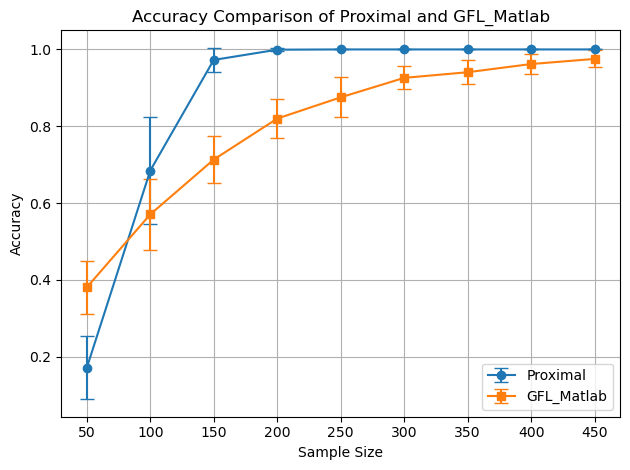

In [39]:
acc_1 = []
acc_2 = []
std_1 = []
std_2 = []

# Extract means and standard deviations for Proximal and GFL_Matlab
for i in range(len(accuracy)):
    mean_1 = np.mean(accuracy[i]['Proximal'])
    stddev_1 = np.std(accuracy[i]['Proximal'])
    acc_1.append(mean_1)
    std_1.append(stddev_1)

    mean_2 = np.mean(accuracy[i]['GFL_Matlab'])
    stddev_2 = np.std(accuracy[i]['GFL_Matlab'])
    acc_2.append(mean_2)
    std_2.append(stddev_2)

# Plot with error bars
plt.errorbar(sample_sizes, acc_1, yerr=std_1, label='Proximal', fmt="-o", capsize=5)
plt.errorbar(sample_sizes, acc_2, yerr=std_2, label='GFL_Matlab', fmt="-s", capsize=5)

# Add labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Proximal and GFL_Matlab')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [41]:
def compute_n(k,d):
    return k * np.log(d-k)

compute_n(30, 1000)

206.31888214492287

In [42]:
compute_n(10,1000)

68.97704943128636

In [ ]:
def compute_n(k,d):
    return k * np.log(d-k)

compute_n(50, 1000)

In [11]:
random_ensemble = RandomEnsembleWeight(n=400, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.7, q=0.02, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GFL_Matlab model
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     2.48722e-05     6.00608e+02     3.99990e+02
         2          3         15     1.00000e+00     4.29382e+02     3.97987e+02
         3          4         26     1.00000e+00     3.45863e+02     3.96955e+02
         4          5         37     1.00000e+00     2.63679e+02     3.95517e+02
         5          6         49     1.00000e+00     2.05971e+02     3.94837e+02
         6          7         61     1.00000e+00     1.62179e+02     3.95887e+02
         7          8         73     1.00000e+00     1.31237e+02     3.95286e+02
         8          9         85     1.00000e+00     1.11599e+02     3.89892e+02
         9         10         97     1.00000e+00     1.01265e+02     3.83114e+02
        10         11        109     1.00000e+00     9.51377e+01     3.73334e+02
        11         12        119     1.00000e+00     8.82455e+

defaultdict(list,
            {'GFL_Matlab': [0.28,
              0.5,
              0.34,
              0.24,
              0.42,
              0.64,
              0.56,
              0.68,
              0.48,
              0.82],
             'Proximal': [0.24,
              0.52,
              0.32,
              0.3,
              0.46,
              0.68,
              0.58,
              0.7,
              0.42,
              0.84]})

In [12]:
random_ensemble = RandomEnsembleWeight(n=500, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.7, q=0.02, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GFL_Matlab model
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     3.16686e-05     4.74625e+02     4.99984e+02
         2          3         15     1.00000e+00     3.44469e+02     4.98320e+02
         3          4         26     1.00000e+00     2.73244e+02     4.97314e+02
         4          5         37     1.00000e+00     2.07019e+02     4.96402e+02
         5          6         48     1.00000e+00     1.59341e+02     4.95998e+02
         6          7         59     1.00000e+00     1.22683e+02     4.95873e+02
         7          8         71     1.00000e+00     9.59500e+01     4.95522e+02
         8          9         83     1.00000e+00     7.76985e+01     4.37507e+02
         9         10         95     1.00000e+00     6.70054e+01     3.33575e+02
        10         11        107     1.00000e+00     6.20795e+01     2.67853e+02
        11         12        118     1.00000e+00     6.06661e+

defaultdict(list,
            {'GFL_Matlab': [0.16,
              0.5,
              0.84,
              0.08,
              0.6,
              0.36,
              0.16,
              0.28,
              0.28,
              0.76],
             'Proximal': [0.36,
              0.44,
              0.84,
              0.1,
              0.64,
              0.36,
              0.44,
              0.64,
              0.34,
              0.76]})

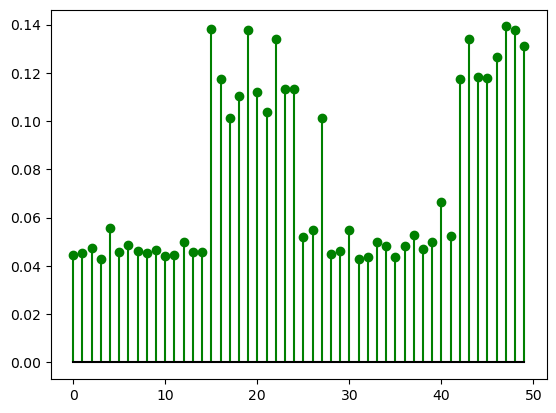

In [ ]:
# extract the results
i = 1
resultfile = f'./res/result_GeneralizedFusedLasso_{i}.mat'
result = sio.loadmat(resultfile)

u = result['beta'].flatten()
plt.stem(u[:50], linefmt='g-', markerfmt='go', basefmt='k')
plt.show()
    

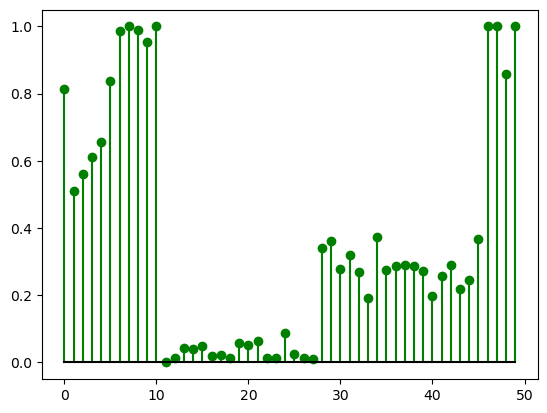

In [46]:
# extract the results
i = 5
resultfile = f'./res/result_GeneralizedFusedLasso_{i}.mat'
result = sio.loadmat(resultfile)

u = result['beta'].flatten()
plt.stem(u[:50], linefmt='g-', markerfmt='go', basefmt='k')
plt.show()

In [ ]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.7, q=0.02, num_replications=10) # change the possible values for rho and mu
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 50, mu: 0.01, mse: 52.758368372342225
rho: 50, mu: 0.05, mse: 45.46211805913508
rho: 50, mu: 0.1, mse: 36.660267387678026
rho: 50, mu: 0.2, mse: 26.615828117752187
rho: 50, mu: 0.3, mse: 22.36836006086515
rho: 50, mu: 0.4, mse: 19.926040950707417
rho: 50, mu: 0.5, mse: 18.30699763500872
rho: 100, mu: 0.01, mse: 56.868359434432726
rho: 100, mu: 0.05, mse: 48.31741514556917
rho: 100, mu: 0.1, mse: 42.59738172968379
rho: 100, mu: 0.2, mse: 31.44767825130782
rho: 100, mu: 0.3, mse: 25.7375100951926
rho: 100, mu: 0.4, mse: 22.511628470438183
rho: 100, mu: 0.5, mse: 20.39173472278592
rho: 200, mu: 0.01, mse: 61.540999930787315
rho: 200, mu: 0.05, mse: 50.67002270026223
rho: 200, mu: 0.1, mse: 45.58713221024326
rho: 200, mu: 0.2, mse: 34.832094503198746
rho: 200, mu: 0.3, mse: 27.827402349740407
rho: 200, mu: 0.4, mse: 23.85168556939309
rho: 200, mu: 0.5, mse: 21.28417017962706
rho: 300, mu: 0.01, mse: 65.03741121824332
rho: 300, m

defaultdict(list,
            {'GeneralizedFusedLasso': [0.44,
              0.78,
              0.68,
              0.5,
              0.68,
              0.38,
              0.56,
              0.64,
              0.4,
              0.42],
             'Proximal': [0.42,
              0.82,
              0.72,
              0.48,
              0.72,
              0.36,
              0.56,
              0.64,
              0.6,
              0.4]})

In [29]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.7, q=0.02, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 10, mu: 0.01, mse: 21.389224798377313
rho: 10, mu: 0.1, mse: 9.03928091558861
rho: 10, mu: 0.5, mse: 7.458338642928512
rho: 10, mu: 1.0, mse: 7.54219041355361
rho: 10, mu: 1.5, mse: 7.6612168890014845
rho: 17.320508075688775, mu: 0.01, mse: 23.29495729094355
rho: 17.320508075688775, mu: 0.1, mse: 10.508002533065895
rho: 17.320508075688775, mu: 0.5, mse: 7.604635724419262
rho: 17.320508075688775, mu: 1.0, mse: 7.5073544239165475
rho: 17.320508075688775, mu: 1.5, mse: 7.579421070363976
rho: 50, mu: 0.01, mse: 26.577298546515713
rho: 50, mu: 0.1, mse: 15.410143333858695
rho: 50, mu: 0.5, mse: 8.418612683787847
rho: 50, mu: 1.0, mse: 7.739364197400008
rho: 50, mu: 1.5, mse: 7.6373392114534155
rho: 100, mu: 0.01, mse: 29.058696021040667
rho: 100, mu: 0.1, mse: 19.156778650910695
rho: 100, mu: 0.5, mse: 9.22017509343544
rho: 100, mu: 1.0, mse: 8.05086386905595
rho: 100, mu: 1.5, mse: 7.801477295124572
Best rho: 10, Best mu: 0.5
Sy

defaultdict(list,
            {'GeneralizedFusedLasso': [0.74,
              0.9,
              0.72,
              0.76,
              0.88,
              0.76,
              0.66,
              0.82,
              0.84,
              0.74],
             'Proximal': [1.0,
              0.98,
              0.98,
              0.88,
              0.94,
              0.98,
              0.9,
              0.92,
              1.0,
              1.0]})

In [30]:
random_ensemble = RandomEnsembleWeight(n=50, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.7, q=0.02, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 10, mu: 0.01, mse: 4.102576107879705
rho: 10, mu: 0.1, mse: 3.1264724979434266
rho: 10, mu: 0.5, mse: 3.2413148768936706
rho: 10, mu: 1.0, mse: 3.2794503097706
rho: 10, mu: 1.5, mse: 3.2946220343703443
rho: 7.0710678118654755, mu: 0.01, mse: 3.773777466343179
rho: 7.0710678118654755, mu: 0.1, mse: 3.1400180273310534
rho: 7.0710678118654755, mu: 0.5, mse: 3.256518375172456
rho: 7.0710678118654755, mu: 1.0, mse: 3.289039767975723
rho: 7.0710678118654755, mu: 1.5, mse: 3.301757286157799
rho: 50, mu: 0.01, mse: 7.00599542902916
rho: 50, mu: 0.1, mse: 3.1622442126198065
rho: 50, mu: 0.5, mse: 3.192160920890319
rho: 50, mu: 1.0, mse: 3.2470692278315747
rho: 50, mu: 1.5, mse: 3.270975241200678
rho: 100, mu: 0.01, mse: 8.212336981096623
rho: 100, mu: 0.1, mse: 3.1652580301891406
rho: 100, mu: 0.5, mse: 3.1989847969270477
rho: 100, mu: 1.0, mse: 3.2535807567086996
rho: 100, mu: 1.5, mse: 3.276533053597921
Best rho: 10, Best mu: 0.1
S

defaultdict(list,
            {'GeneralizedFusedLasso': [0.12,
              0.26,
              0.34,
              0.22,
              0.14,
              0.3,
              0.22,
              0.32,
              0.16,
              0.3],
             'Proximal': [0.16,
              0.42,
              0.36,
              0.28,
              0.24,
              0.4,
              0.24,
              0.48,
              0.26,
              0.32]})

In [36]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.6, q=0.01, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 10, mu: 0.01, acc: 0.22800000000000004
rho: 10, mu: 0.1, acc: 0.21600000000000003
rho: 10, mu: 0.5, acc: 0.23600000000000004
rho: 10, mu: 1.0, acc: 0.23199999999999998
rho: 10, mu: 1.5, acc: 0.22799999999999998
rho: 17.320508075688775, mu: 0.01, acc: 0.22000000000000003
rho: 17.320508075688775, mu: 0.1, acc: 0.23200000000000004
rho: 17.320508075688775, mu: 0.5, acc: 0.22400000000000003
rho: 17.320508075688775, mu: 1.0, acc: 0.22400000000000003
rho: 17.320508075688775, mu: 1.5, acc: 0.22800000000000004
rho: 50, mu: 0.01, acc: 0.20400000000000001
rho: 50, mu: 0.1, acc: 0.22400000000000003
rho: 50, mu: 0.5, acc: 0.22000000000000003
rho: 50, mu: 1.0, acc: 0.22799999999999998
rho: 50, mu: 1.5, acc: 0.22799999999999998
rho: 100, mu: 0.01, acc: 0.196
rho: 100, mu: 0.1, acc: 0.22400000000000003
rho: 100, mu: 0.5, acc: 0.22000000000000003
rho: 100, mu: 1.0, acc: 0.22000000000000003
rho: 100, mu: 1.5, acc: 0.23199999999999998
Best rho

defaultdict(list,
            {'GeneralizedFusedLasso': [0.22,
              0.74,
              0.56,
              0.44,
              0.32,
              0.66,
              0.5,
              0.64,
              0.24,
              0.48],
             'Proximal': [0.62,
              0.74,
              0.66,
              0.56,
              0.36,
              0.7,
              0.58,
              0.7,
              0.68,
              0.72]})

In [87]:
random_ensemble = RandomEnsemble(n=300, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.6, q=0.01, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GFL_Matlab model
Paths in MATLAB:
/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/minConF:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/DuchiEtAl_UAI2008:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/GGM:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/KPM:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/L1General:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/L1General/sub:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/UGM:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/UGM/compiled:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/UGM/decode:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/UGM/examples:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/UGM/infer:/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/PQN/UGM/mex:/Users/aolongl

defaultdict(list,
            {'GFL_Matlab': [0.9,
              0.86,
              0.88,
              0.92,
              0.9,
              0.86,
              0.84,
              0.86,
              0.86,
              0.9]})

In [8]:
random_ensemble = RandomEnsemble(n=300, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.6, q=0.01, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GFL_Matlab model
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     8.99282e-05     1.46573e+02     2.99973e+02
         2          3         15     1.00000e+00     1.04503e+02     2.98296e+02
         3          4         27     1.00000e+00     8.51635e+01     2.97128e+02
         4          5         39     1.00000e+00     6.68492e+01     2.95403e+02
         5          6         51     1.00000e+00     5.46679e+01     2.94334e+02
         6          7         63     1.00000e+00     4.52207e+01     2.90876e+02
         7          8         74     1.00000e+00     3.77325e+01     2.80974e+02
         8          9         86     1.00000e+00     3.14792e+01     2.69001e+02
         9         10         98     1.00000e+00     2.55803e+01     2.45023e+02
        10         11        109     1.00000e+00     1.91562e+01     1.67051e+02
        11         12        120     1.00000e+00     1.68827e+

defaultdict(list,
            {'GFL_Matlab': [0.86,
              0.92,
              0.96,
              0.86,
              0.9,
              0.88,
              0.86,
              0.86,
              0.92,
              0.88],
             'Proximal': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]})

In [7]:
random_ensemble = RandomEnsemble(n=300, d=1000, k=50, h_total=15, h_selected=5, h_rest=10, gamma=0.1, p=0.8, q=0.01, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GFL_Matlab model
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     1.08797e-04     1.22628e+02     2.99967e+02
         2          3         15     1.00000e+00     9.01113e+01     2.98545e+02
         3          4         27     1.00000e+00     7.58442e+01     2.98448e+02
         4          5         39     1.00000e+00     6.20776e+01     2.97997e+02
         5          6         51     1.00000e+00     5.05931e+01     2.95180e+02
         6          7         63     1.00000e+00     4.00223e+01     2.85923e+02
         7          8         75     1.00000e+00     3.44316e+01     2.98504e+02
         8          9         86     1.00000e+00     2.90622e+01     2.85046e+02
         9         10         98     1.00000e+00     2.73079e+01     2.70038e+02
        10         11        109     1.00000e+00     2.46465e+01     2.51857e+02
        11         12        120     1.00000e+00     2.18873e+

defaultdict(list,
            {'GFL_Matlab': [0.94,
              0.98,
              0.98,
              0.98,
              1.0,
              1.0,
              1.0,
              0.96,
              1.0,
              0.98],
             'Proximal': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]})

In [41]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.6, q=0.01, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 10, mu: 0.01, acc: 0.9200000000000002
rho: 10, mu: 0.1, acc: 0.8640000000000001
rho: 10, mu: 0.5, acc: 0.8480000000000001
rho: 10, mu: 1.0, acc: 0.8240000000000001
rho: 10, mu: 1.5, acc: 0.8160000000000001
rho: 17.320508075688775, mu: 0.01, acc: 0.9200000000000002
rho: 17.320508075688775, mu: 0.1, acc: 0.868
rho: 17.320508075688775, mu: 0.5, acc: 0.852
rho: 17.320508075688775, mu: 1.0, acc: 0.8240000000000001
rho: 17.320508075688775, mu: 1.5, acc: 0.8119999999999999
rho: 50, mu: 0.01, acc: 0.884
rho: 50, mu: 0.1, acc: 0.86
rho: 50, mu: 0.5, acc: 0.82
rho: 50, mu: 1.0, acc: 0.804
rho: 50, mu: 1.5, acc: 0.784
rho: 100, mu: 0.01, acc: 0.8119999999999999
rho: 100, mu: 0.1, acc: 0.828
rho: 100, mu: 0.5, acc: 0.7959999999999999
rho: 100, mu: 1.0, acc: 0.764
rho: 100, mu: 1.5, acc: 0.736
Best rho: 10, Best mu: 0.01
Synthetic dataset 1: Running Proximal model
911 913
911 913
911 913
911 913
911 913
911 913
911 913
911 913
911 913
91

defaultdict(list,
            {'GeneralizedFusedLasso': [0.84,
              0.76,
              0.98,
              0.72,
              0.94,
              0.8,
              1.0,
              0.84,
              0.92,
              0.88],
             'Proximal': [1.0,
              0.96,
              0.98,
              1.0,
              1.0,
              0.82,
              1.0,
              0.94,
              0.96,
              1.0]})

In [42]:
random_ensemble = RandomEnsembleWeight(n=500, d=1000, k=50, h_total=60, h_selected=10, h_rest=50, gamma=0.1, p=0.6, q=0.01, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 10, mu: 0.01, acc: 0.976
rho: 10, mu: 0.1, acc: 0.9199999999999999
rho: 10, mu: 0.5, acc: 0.8400000000000001
rho: 10, mu: 1.0, acc: 0.808
rho: 10, mu: 1.5, acc: 0.7879999999999999
rho: 22.360679774997898, mu: 0.01, acc: 0.9559999999999998
rho: 22.360679774997898, mu: 0.1, acc: 0.9119999999999999
rho: 22.360679774997898, mu: 0.5, acc: 0.844
rho: 22.360679774997898, mu: 1.0, acc: 0.8160000000000001
rho: 22.360679774997898, mu: 1.5, acc: 0.792
rho: 50, mu: 0.01, acc: 0.908
rho: 50, mu: 0.1, acc: 0.8800000000000001
rho: 50, mu: 0.5, acc: 0.828
rho: 50, mu: 1.0, acc: 0.788
rho: 50, mu: 1.5, acc: 0.7719999999999999
rho: 100, mu: 0.01, acc: 0.8240000000000001
rho: 100, mu: 0.1, acc: 0.836
rho: 100, mu: 0.5, acc: 0.78
rho: 100, mu: 1.0, acc: 0.76
rho: 100, mu: 1.5, acc: 0.728
Best rho: 10, Best mu: 0.01
Synthetic dataset 1: Running Proximal model
853 855
853 855
853 855
853 855
853 855
853 855
853 855
853 855
853 855
853 855
853 855

defaultdict(list,
            {'GeneralizedFusedLasso': [0.82,
              1.0,
              0.94,
              1.0,
              1.0,
              1.0,
              0.96,
              1.0,
              1.0,
              0.94],
             'Proximal': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 1.0, 1.0, 0.98]})

In [43]:
# create a new random ensemble, overwrite the generate_X method

class RandomEnsembleCorr(RandomEnsemble):
    def _generate_X(self):
        # randomly choose some selected features to be correlated with non-selected features
        X = np.random.normal(0, 1, (self.n, self.d))
        selected_features = np.random.choice(range(self.d), self.k, replace=False)
        non_selected_features = np.setdiff1d(range(self.d), selected_features)
        num_correlated = int(0.2 * self.k)
        correlated_pairs = random.sample(list(itertools.product(selected_features, non_selected_features)), num_correlated)
        mean = np.zeros(self.d)
        cov = np.eye(self.d)
        for i, j in correlated_pairs:
            cov[i, j] = 0.9
            cov[j, i] = 0.9

        X = np.random.multivariate_normal(mean, cov, self.n)
        return X
        


In [44]:
random_ensemble = RandomEnsembleCorr(n=300, d=1000, k=50, h_total=50, h_selected=8, h_rest=42, gamma=0.1, p=0.6, q=0.01, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 10, mu: 0.01, acc: 0.9960000000000001
rho: 10, mu: 0.1, acc: 0.96
rho: 10, mu: 0.5, acc: 0.9279999999999999
rho: 10, mu: 1.0, acc: 0.916
rho: 10, mu: 1.5, acc: 0.9120000000000001
rho: 17.320508075688775, mu: 0.01, acc: 0.9960000000000001
rho: 17.320508075688775, mu: 0.1, acc: 0.9559999999999998
rho: 17.320508075688775, mu: 0.5, acc: 0.9359999999999999
rho: 17.320508075688775, mu: 1.0, acc: 0.916
rho: 17.320508075688775, mu: 1.5, acc: 0.9199999999999999
rho: 50, mu: 0.01, acc: 0.9800000000000001
rho: 50, mu: 0.1, acc: 0.9480000000000001
rho: 50, mu: 0.5, acc: 0.9199999999999999
rho: 50, mu: 1.0, acc: 0.9040000000000001
rho: 50, mu: 1.5, acc: 0.8960000000000001
rho: 100, mu: 0.01, acc: 0.9359999999999999
rho: 100, mu: 0.1, acc: 0.932
rho: 100, mu: 0.5, acc: 0.9
rho: 100, mu: 1.0, acc: 0.8800000000000001
rho: 100, mu: 1.5, acc: 0.876
Best rho: 10, Best mu: 0.01
Synthetic dataset 1: Running Proximal model
699 701
699 701
699 701

/var/folders/1z/cz7sgb1n2zz05wf6l692bzl00000gn/T/ipykernel_83313/2776265982.py:17: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = np.random.multivariate_normal(mean, cov, self.n)


Synthetic dataset 2: Running GeneralizedFusedLasso model
Synthetic dataset 2: Running Proximal model
724 726
724 726
724 726
724 726
724 726
724 726
724 726
724 726
724 726
724 726
724 726
724 726
706 708
691 693
620 622
562 564
535 537
471 473
428 430
365 367
324 326
262 264
223 225
195 197
166 168
140 142
117 119
95 97
81 83
74 76
66 68
52 54
50 52
50 52
50 52
53 55
52 54
51 53
53 55
55 57
55 57
54 56
53 55
56 58
57 59
Synthetic dataset 3: Running GeneralizedFusedLasso model
Synthetic dataset 3: Running Proximal model
762 764
762 764
762 764
762 764
762 764
762 764
762 764
762 764
762 764
762 764
762 764
762 764
771 773
742 744
686 688
613 615
550 552
437 439
373 375
315 317
271 273
240 242
203 205
173 175
143 145
126 128
113 115
97 99
82 84
74 76
68 70
61 63
65 67
64 66
62 64
60 62
60 62
60 62
59 61
60 62
63 65
60 62
58 60
Synthetic dataset 4: Running GeneralizedFusedLasso model
Synthetic dataset 4: Running Proximal model
736 738
736 738
736 738
736 738
736 738
736 738
736 738
736 7

defaultdict(list,
            {'GeneralizedFusedLasso': [0.98,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              0.98,
              1.0,
              1.0],
             'Proximal': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 1.0, 1.0]})

In [45]:
random_ensemble = RandomEnsembleWeight(n=300, d=1000, k=50, h_total=53, h_selected=8, h_rest=45, gamma=0.1, p=0.7, q=0.01, num_replications=10)
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 10, mu: 0.01, acc: 0.644
rho: 10, mu: 0.1, acc: 0.648
rho: 10, mu: 0.5, acc: 0.636
rho: 10, mu: 1.0, acc: 0.62
rho: 10, mu: 1.5, acc: 0.616
rho: 17.320508075688775, mu: 0.01, acc: 0.628
rho: 17.320508075688775, mu: 0.1, acc: 0.652
rho: 17.320508075688775, mu: 0.5, acc: 0.632
rho: 17.320508075688775, mu: 1.0, acc: 0.62
rho: 17.320508075688775, mu: 1.5, acc: 0.616
rho: 50, mu: 0.01, acc: 0.608
rho: 50, mu: 0.1, acc: 0.636
rho: 50, mu: 0.5, acc: 0.628
rho: 50, mu: 1.0, acc: 0.62
rho: 50, mu: 1.5, acc: 0.612
rho: 100, mu: 0.01, acc: 0.592
rho: 100, mu: 0.1, acc: 0.616
rho: 100, mu: 0.5, acc: 0.62
rho: 100, mu: 1.0, acc: 0.612
rho: 100, mu: 1.5, acc: 0.612
Best rho: 17.320508075688775, Best mu: 0.1
Synthetic dataset 1: Running Proximal model
880 882
880 882
880 882
880 882
880 882
880 882
880 882
880 882
880 882
880 882
880 882
880 882
893 895
909 911
895 897
887 889
869 871
833 835
796 798
700 702
661 663
609 611
569 571
524 526

defaultdict(list,
            {'GeneralizedFusedLasso': [0.62,
              1.0,
              0.78,
              0.72,
              0.9,
              0.66,
              0.7,
              0.7,
              0.98,
              0.8],
             'Proximal': [0.88,
              1.0,
              1.0,
              0.98,
              1.0,
              0.84,
              1.0,
              1.0,
              1.0,
              1.0]})

In [56]:
random_ensemble = RandomEnsembleWeight(n=100, d=1000, k=50, h_total=53, h_selected=8, h_rest=45, gamma=0.1, p=0.7, q=0.01, num_replications=10, options={'maxIter': 1000, 'verbose': 3})
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
Running PQN...
Number of L-BFGS Corrections to store: 10
Spectral initialization of SPG: 0
Maximum number of SPG iterations: 10
SPG optimality tolerance: 1.00e-06
SPG progress tolerance: 1.00e-10
PQN optimality tolerance: 1.00e-06
Quadratic initialization of line search: 0
Maximum number of function evaluations: 1000
Maximum number of projections: 100000
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     1.26760e-03     4.66025e+01     9.13148e+01
         2          3         16     1.00000e+00     3.31343e+01     8.01712e+01
         3          4         28     1.00000e+00     2.70327e+01     6.97000e+01
         4          5         40     1.00000e+00     2.16116e+01     5.02683e+01
         5          6         52     1.00000e+00     1.86530e+01     3.10093e+01
         6          7         62     1.00000e+00     1.72065e+01     1.75763e+01
         7        

defaultdict(list,
            {'GeneralizedFusedLasso': [0.54,
              0.44,
              0.44,
              0.52,
              0.44,
              0.48,
              0.52,
              0.5,
              0.44,
              0.6],
             'Proximal': [0.72,
              0.84,
              0.78,
              0.8,
              0.98,
              0.76,
              0.96,
              0.76,
              0.86,
              0.98]})

In [57]:
random_ensemble = RandomEnsembleWeight(n=20, d=100, k=15, h_total=8, h_selected=3, h_rest=5, gamma=0.1, p=0.7, q=0.01, num_replications=10, options={'maxIter': 1000, 'verbose': 3})
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
Running PQN...
Number of L-BFGS Corrections to store: 10
Spectral initialization of SPG: 0
Maximum number of SPG iterations: 10
SPG optimality tolerance: 1.00e-06
SPG progress tolerance: 1.00e-10
PQN optimality tolerance: 1.00e-06
Quadratic initialization of line search: 0
Maximum number of function evaluations: 1000
Maximum number of projections: 100000
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     1.54653e-02     7.73035e+00     8.15195e+00
         2          3         16     1.00000e+00     5.56173e+00     6.42156e+00
         3          4         27     1.00000e+00     4.49172e+00     5.16496e+00
         4          5         39     1.00000e+00     3.64919e+00     3.06293e+00
         5          6         49     1.00000e+00     3.21083e+00     1.50947e+00
         6          7         57     1.00000e+00     3.10213e+00     8.12464e-01
         7        

defaultdict(list,
            {'GeneralizedFusedLasso': [1.0,
              1.0,
              0.8,
              1.0,
              0.6,
              0.6,
              1.0,
              1.0,
              0.6,
              0.8],
             'Proximal': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0]})

In [63]:
random_ensemble = RandomEnsemble(n=20, d=100, k=15, h_total=8, h_selected=3, h_rest=5, gamma=0.1, p=0.7, q=0.01, num_replications=10, options={'maxIter': 1000, 'verbose': 0})
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 0.1, mu: 0.01, acc: 0.42666666666666664
rho: 0.1, mu: 0.1, acc: 0.37333333333333335
rho: 0.1, mu: 1.0, acc: 0.33333333333333337
rho: 0.5, mu: 0.01, acc: 0.4666666666666666
rho: 0.5, mu: 0.1, acc: 0.4133333333333334
rho: 0.5, mu: 1.0, acc: 0.33333333333333337
rho: 1.0, mu: 0.01, acc: 0.5066666666666666
rho: 1.0, mu: 0.1, acc: 0.4133333333333333
rho: 1.0, mu: 1.0, acc: 0.33333333333333337
rho: 5.0, mu: 0.01, acc: 0.49333333333333335
rho: 5.0, mu: 0.1, acc: 0.4533333333333333
rho: 5.0, mu: 1.0, acc: 0.37333333333333335
Best rho: 1.0, Best mu: 0.01
Synthetic dataset 1: Running Proximal model
54 56
54 56
54 56
54 56
54 56
54 56
54 56
54 56
50 52
43 45
35 37
26 28
26 28
25 27
23 25
23 25
19 21
17 19
16 18
11 13
13 15
12 14
11 13
9 11
9 11
10 12
9 11
8 10
7 9
8 10
Synthetic dataset 2: Running GeneralizedFusedLasso model
Synthetic dataset 2: Running Proximal model
46 48
46 48
46 48
46 48
46 48
46 48
46 48
46 48
48 50
33 35
31 33
28 

defaultdict(list,
            {'GeneralizedFusedLasso': [0.26666666666666666,
              0.8,
              0.6,
              0.9333333333333333,
              0.8666666666666667,
              0.8666666666666667,
              0.8,
              0.26666666666666666,
              1.0,
              0.8],
             'Proximal': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]})

In [66]:
random_ensemble = RandomEnsemble(n=20, d=100, k=15, h_total=8, h_selected=3, h_rest=5, gamma=0.1, p=0.7, q=0.01, num_replications=10, options={'maxIter': 1000, 'verbose': 0})
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 0.1, mu: 0.01, acc: 0.6266666666666667
rho: 0.1, mu: 0.1, acc: 0.6133333333333333
rho: 0.1, mu: 1.0, acc: 0.6666666666666666
rho: 0.5, mu: 0.01, acc: 0.5733333333333335
rho: 0.5, mu: 0.1, acc: 0.5866666666666667
rho: 0.5, mu: 1.0, acc: 0.6133333333333333
rho: 1.0, mu: 0.01, acc: 0.5466666666666666
rho: 1.0, mu: 0.1, acc: 0.6
rho: 1.0, mu: 1.0, acc: 0.6266666666666666
rho: 5.0, mu: 0.01, acc: 0.5066666666666666
rho: 5.0, mu: 0.1, acc: 0.5866666666666667
rho: 5.0, mu: 1.0, acc: 0.6133333333333333
Best rho: 0.1, Best mu: 1.0
Synthetic dataset 1: Running Proximal model
37 39
37 39
37 39
37 39
37 39
37 39
37 39
37 39
31 33
35 37
36 38
36 38
33 35
29 31
24 26
17 19
19 21
17 19
14 16
16 18
15 17
14 16
14 16
16 18
10 12
11 13
11 13
12 14
12 14
12 14
12 14
12 14
12 14
13 15
13 15
Synthetic dataset 2: Running GeneralizedFusedLasso model
Synthetic dataset 2: Running Proximal model
49 51
49 51
49 51
49 51
49 51
49 51
49 51
49 51
39 41
3

defaultdict(list,
            {'GeneralizedFusedLasso': [0.7333333333333333,
              0.6,
              0.8,
              0.8666666666666667,
              0.26666666666666666,
              0.9333333333333333,
              1.0,
              0.5333333333333333,
              0.2,
              0.9333333333333333],
             'Proximal': [1.0,
              0.9333333333333333,
              1.0,
              1.0,
              0.9333333333333333,
              1.0,
              1.0,
              0.9333333333333333,
              0.8666666666666667,
              1.0]})

In [71]:
random_ensemble = RandomEnsemble(n=20, d=100, k=5, h_total=5, h_selected=2, h_rest=3, gamma=0.1, p=0.8, q=0.02, num_replications=10, options={'maxIter': 1000, 'verbose': 0})
random_ensemble.main()

Synthetic dataset 1: Running GeneralizedFusedLasso model
rho: 0.1, mu: 0.01, acc: 1.0
rho: 0.1, mu: 0.1, acc: 1.0
rho: 0.1, mu: 1.0, acc: 1.0
rho: 0.5, mu: 0.01, acc: 1.0
rho: 0.5, mu: 0.1, acc: 1.0
rho: 0.5, mu: 1.0, acc: 1.0
rho: 1.0, mu: 0.01, acc: 1.0
rho: 1.0, mu: 0.1, acc: 1.0
rho: 1.0, mu: 1.0, acc: 1.0
rho: 5.0, mu: 0.01, acc: 0.96
rho: 5.0, mu: 0.1, acc: 1.0
rho: 5.0, mu: 1.0, acc: 1.0
Best rho: 0.1, Best mu: 0.01
Synthetic dataset 1: Running Proximal model
21 23
21 23
21 23
21 23
21 23
21 23
21 23
13 15
8 10
7 9
7 9
6 8
4 6
3 5
3 5
3 5
3 5
3 5
3 5
3 5
Synthetic dataset 2: Running GeneralizedFusedLasso model
Synthetic dataset 2: Running Proximal model
20 22
20 22
20 22
20 22
20 22
20 22
20 22
21 23
17 19
12 14
13 15
10 12
6 8
4 6
4 6
3 5
3 5
3 5
3 5
3 5
3 5
3 5
3 5
Synthetic dataset 3: Running GeneralizedFusedLasso model
Synthetic dataset 3: Running Proximal model
16 18
16 18
16 18
16 18
16 18
16 18
16 18
9 11
7 9
5 7
4 6
5 7
4 6
4 6
4 6
4 6
4 6
4 6
4 6
4 6
4 6
4 6
4 6
4 6
4 6

defaultdict(list,
            {'GeneralizedFusedLasso': [1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              0.8],
             'Proximal': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]})